# **1/ IMPORT & LOAD DATA**



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('../data/real_estate.csv')

In [3]:
print("\n<Dataset's information>:")
print(f"1. Size: {data.shape}")
print(f"2. Number of samples: {data.shape[0]}")
print(f"3. Number of features: {data.shape[1]}")
print("\n4. Description:")
print(data.describe())
print(f"\n5. Number of NaN values: {data.isnull().sum()}")
print(f"\n6. Number of duplicates: {data.duplicated().sum()}")


<Dataset's information>:
1. Size: (414, 8)
2. Number of samples: 414
3. Number of features: 8

4. Description:
               No  X1 transaction date  X2 house age  \
count  414.000000           414.000000    414.000000   
mean   207.500000          2013.148971     17.712560   
std    119.655756             0.281967     11.392485   
min      1.000000          2012.667000      0.000000   
25%    104.250000          2012.917000      9.025000   
50%    207.500000          2013.167000     16.100000   
75%    310.750000          2013.417000     28.150000   
max    414.000000          2013.583000     43.800000   

       X3 distance to the nearest MRT station  \
count                              414.000000   
mean                              1083.885689   
std                               1262.109595   
min                                 23.382840   
25%                                289.324800   
50%                                492.231300   
75%                               1454.2

# **2/ DATA PREPROCESSING**

### 2.1/ Rename & Clean Features

In [4]:
data.columns = ['No', 'transaction_date', 'house_age', 'distance_to_MRT',
              'convenience_stores', 'latitude', 'longitude', 'house_price']

In [5]:
data.drop(['No', 'transaction_date'], axis=1, inplace=True)

### 2.2/ Exploratory Data Analysis

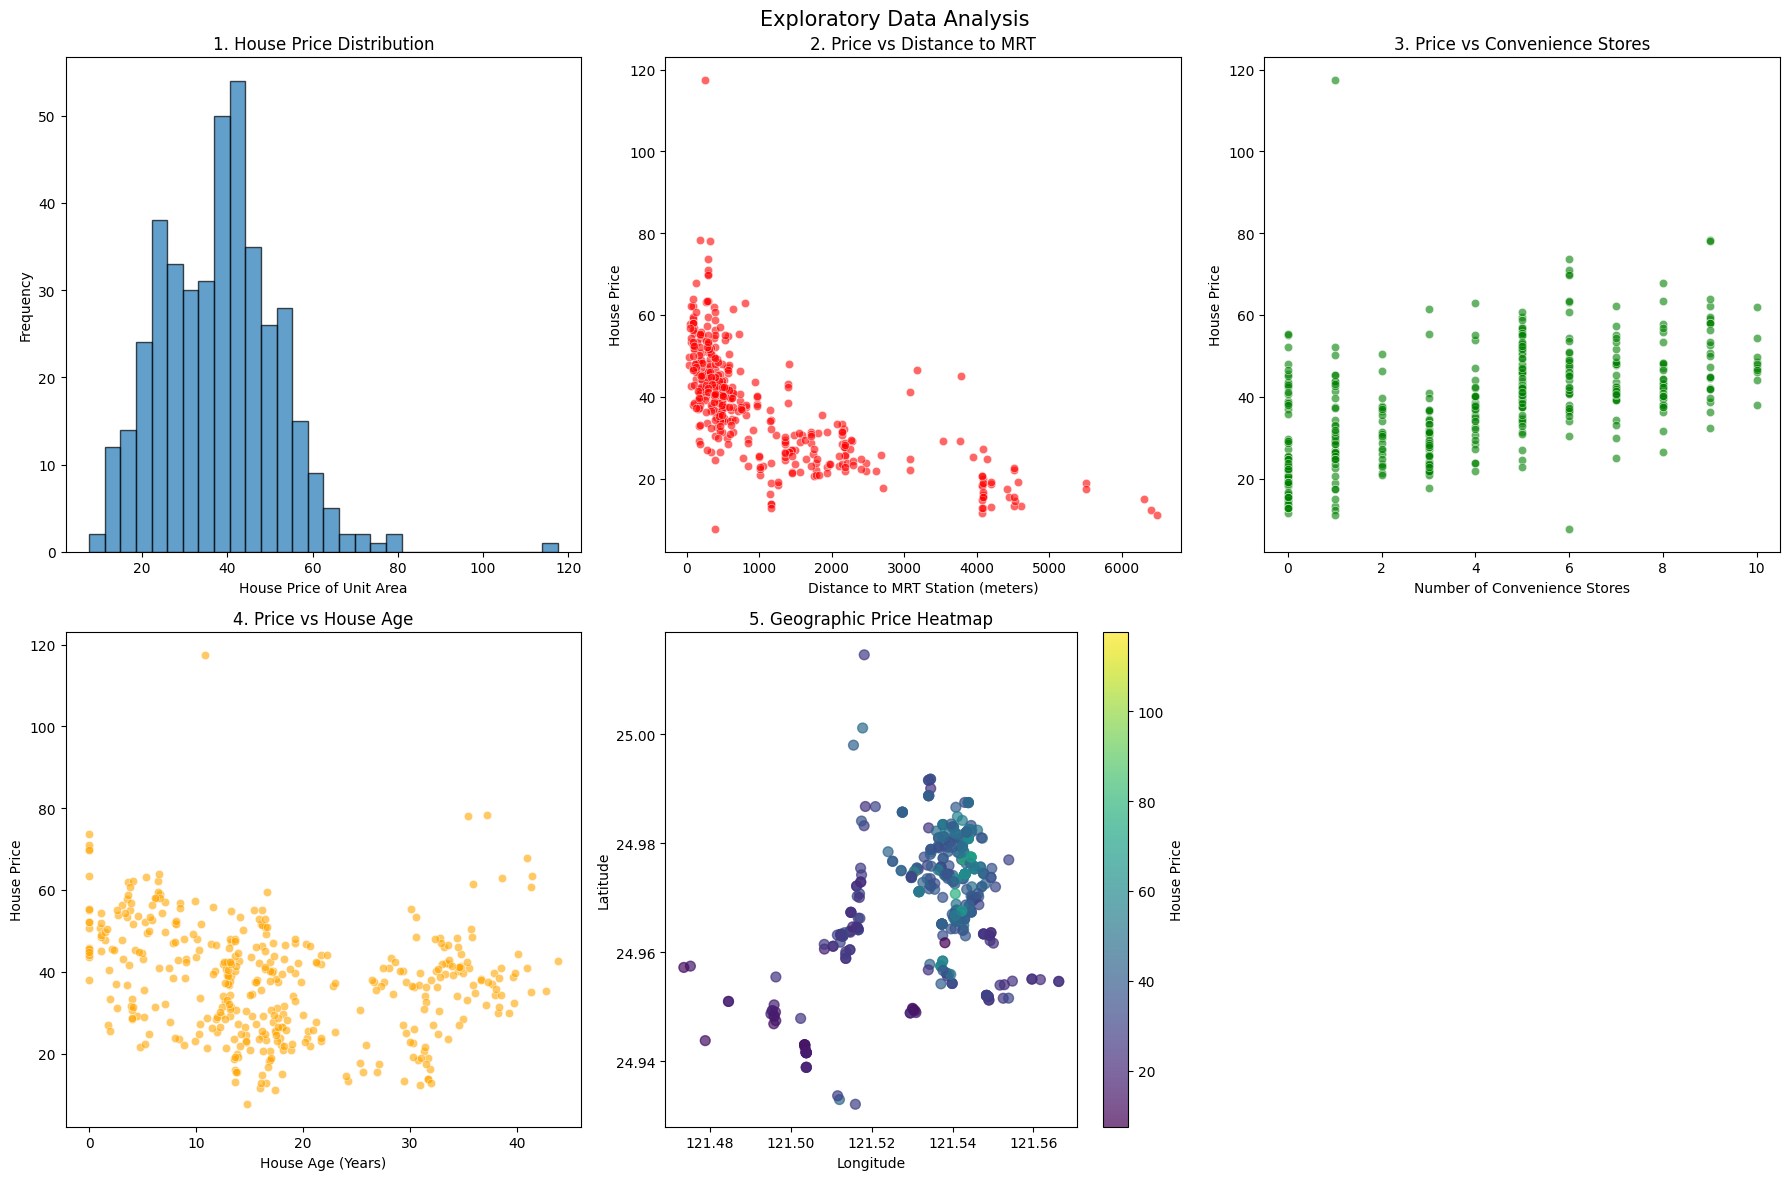

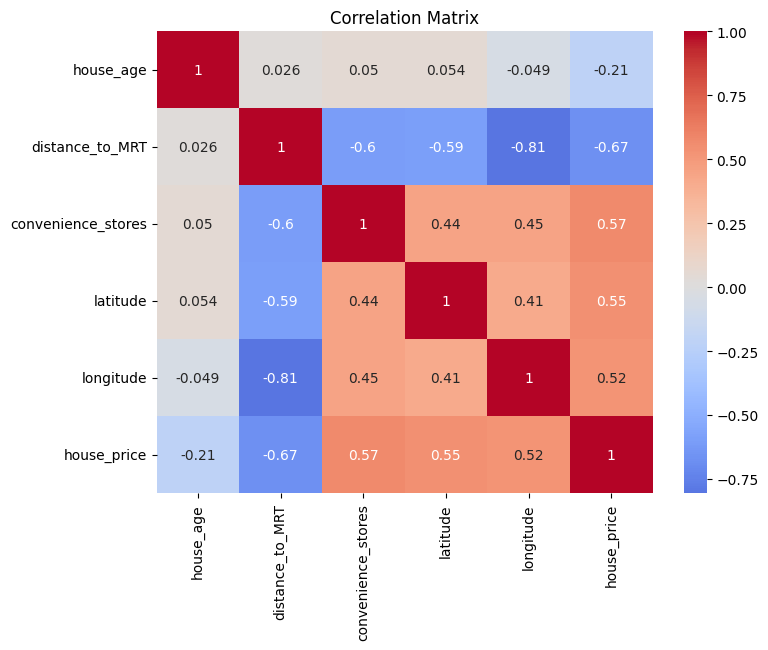

In [6]:
def plot_target_relationships(data):

    plt.figure(figsize=(18, 12))
    plt.suptitle('Exploratory Data Analysis', fontsize=15)

    plt.subplot(2, 3, 1)
    plt.hist(data['house_price'], bins=30, edgecolor='black', alpha=0.7)
    plt.title('1. House Price Distribution')
    plt.xlabel('House Price of Unit Area')
    plt.ylabel('Frequency')

    plt.subplot(2, 3, 2)
    sns.scatterplot(x=data['distance_to_MRT'], y=data['house_price'], alpha=0.6, color='red')
    plt.title('2. Price vs Distance to MRT')
    plt.xlabel('Distance to MRT Station (meters)')
    plt.ylabel('House Price')

    plt.subplot(2, 3, 3)
    sns.scatterplot(x=data['convenience_stores'], y=data['house_price'], alpha=0.6, color='green')
    plt.title('3. Price vs Convenience Stores')
    plt.xlabel('Number of Convenience Stores')
    plt.ylabel('House Price')

    plt.subplot(2, 3, 4)
    sns.scatterplot(x=data['house_age'], y=data['house_price'], alpha=0.6, color='orange')
    plt.title('4. Price vs House Age')
    plt.xlabel('House Age (Years)')
    plt.ylabel('House Price')

    plt.subplot(2, 3, 5)
    scatter = plt.scatter(data['longitude'], data['latitude'], c=data['house_price'], cmap='viridis', alpha=0.7, s=50)
    plt.colorbar(scatter, label='House Price')
    plt.title('5. Geographic Price Heatmap')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.tight_layout()
    plt.show()

def plot_correlation_matrix(data): 
    plt.figure(figsize=(8, 6))
    sns.heatmap(data.corr(), annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix')
    plt.show()


plot_target_relationships(data)
plot_correlation_matrix(data)



### 2.3/ Log Transformation & Outlier Removal

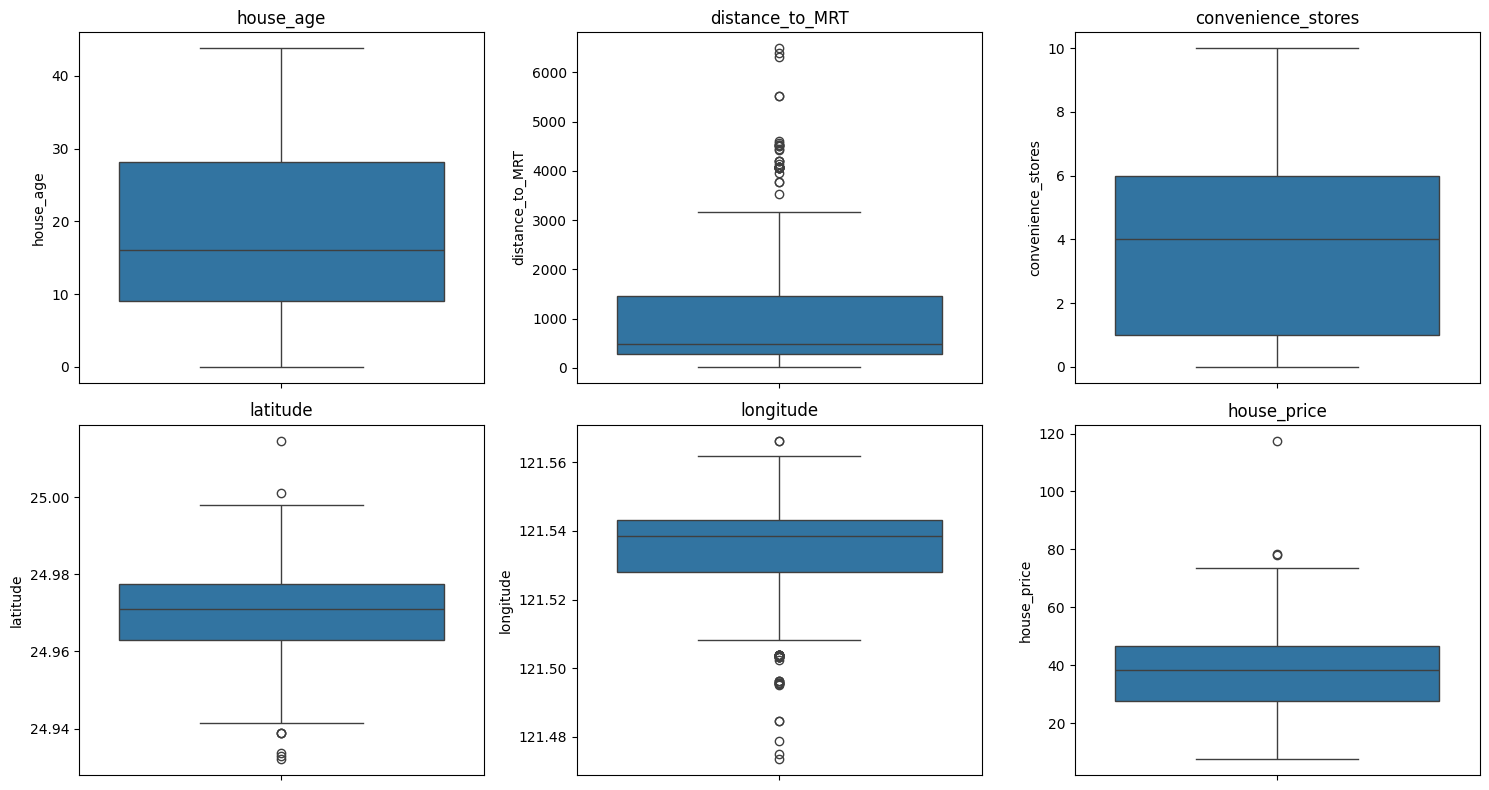

In [7]:
def view_outliers(df):
    plt.figure(figsize=(15, 8))
    for i, col in enumerate(df.columns):
        plt.subplot(2, 3, i + 1)
        sns.boxplot(y=df[col])
        plt.title(col)
    plt.tight_layout()
    plt.show()

view_outliers(data)

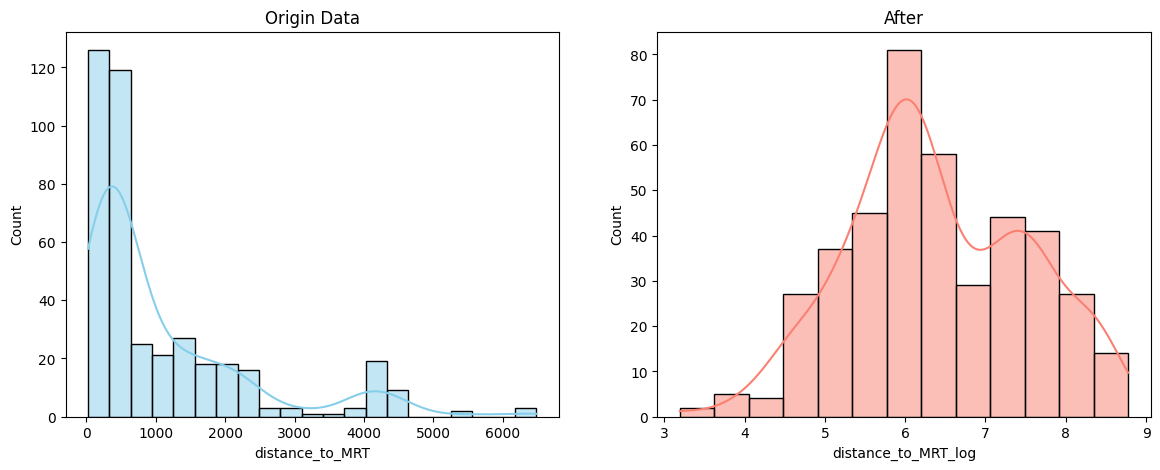

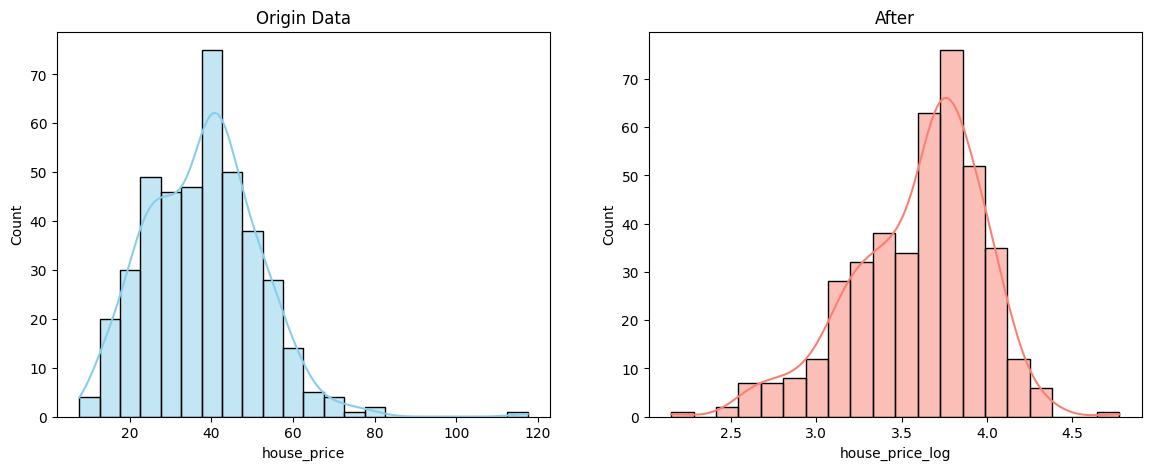

In [ ]:
def plot_log_transform(data):
    tmp_data = data.copy()
    tmp_data['distance_to_MRT_log'] = np.log1p(tmp_data['distance_to_MRT'])
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.histplot(tmp_data['distance_to_MRT'], kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title('Original Data')
    sns.histplot(tmp_data['distance_to_MRT_log'], kde=True, ax=axes[1], color='salmon')
    axes[1].set_title('After')

    plt.show()

    tmp_data['house_price_log'] = np.log1p(tmp_data['house_price'])
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.histplot(tmp_data['house_price'], kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title('Original Data')
    sns.histplot(tmp_data['house_price_log'], kde=True, ax=axes[1], color='salmon')
    axes[1].set_title('After')

    plt.show()

plot_log_transform(data)

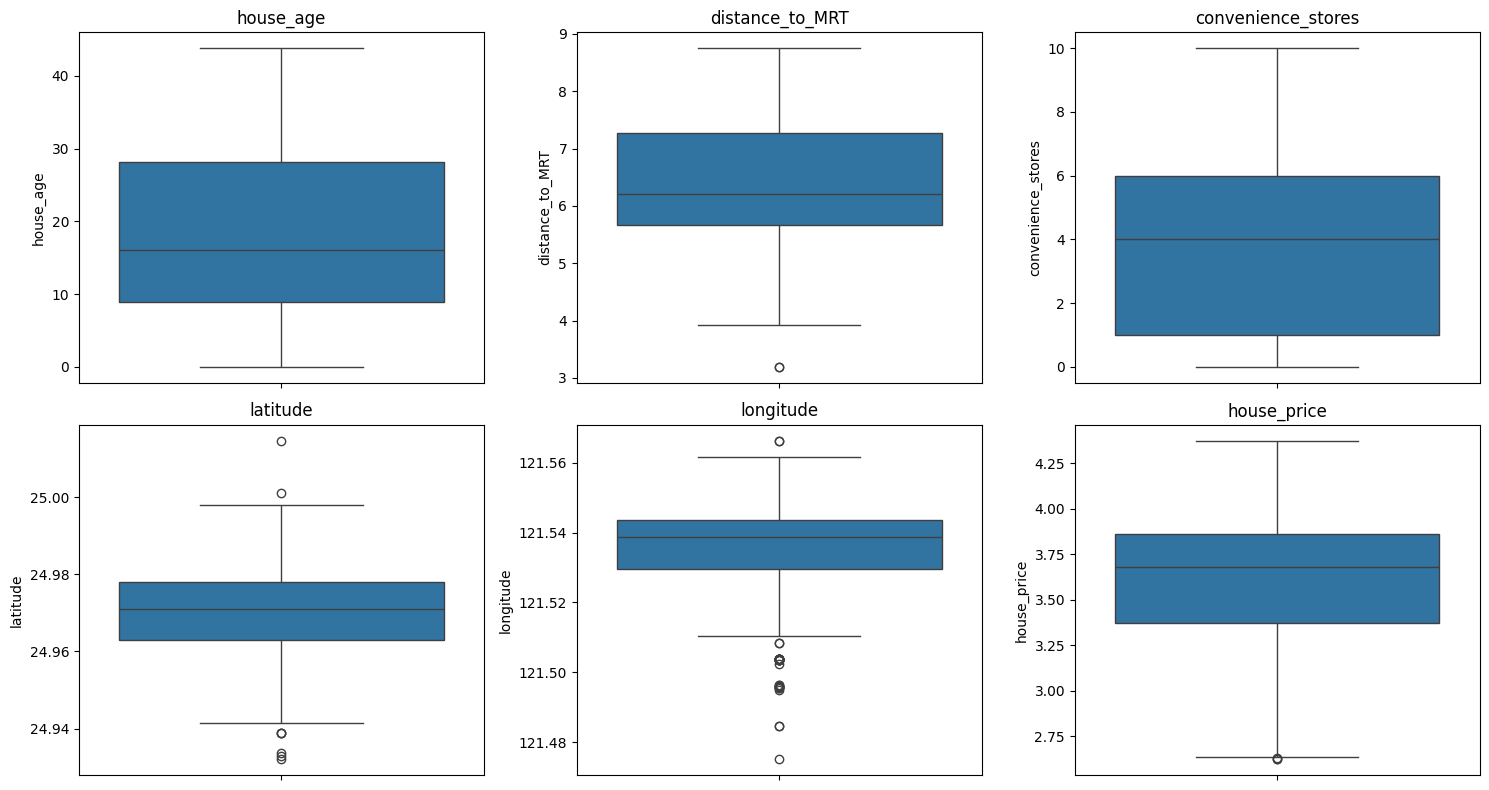

In [9]:
data['distance_to_MRT'] = np.log1p(data['distance_to_MRT'])
data['house_price'] = np.log1p(data['house_price'])

Q1 = data['house_price'].quantile(0.25)
Q3 = data['house_price'].quantile(0.75)
IQR = Q3 - Q1

mask = (
    (data['house_price'] >= Q1 - 1.5 * IQR) &
    (data['house_price'] <= Q3 + 1.5 * IQR)
)
data = data[mask]
view_outliers(data)

### 2.4/ Train–Test Split & Scaling

In [10]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['house_price'])
y = data['house_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Min-Max scaling (train statistics only)
for col in X_train.columns:
  X_train_max = X_train[col].max()
  X_train_min = X_train[col].min()
  X_train[col] = (X_train[col] - X_train_min) / (X_train_max - X_train_min)
  X_test[col] = (X_test[col] - X_train_min) / (X_train_max - X_train_min)

# **3/ HOUSE PRICE PREDICTION MODELS**

### 3.1/ Helper Metrics & Utilities

In [12]:
def regression_metrics(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    mape = np.mean(np.abs((y_pred - y_true) / y_true))

    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_res = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - ss_res / ss_tot if ss_tot != 0 else 0.0

    return {
        "R2": r2,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape
    }

In [13]:
def evaluate_log_predictions(y_log_true, y_log_pred, metric_key=None):
    y_true = np.asarray(np.expm1(y_log_true))
    y_pred = np.asarray(np.expm1(y_log_pred))

    if metric_key is None:
        return regression_metrics(y_true, y_pred)
    
    return regression_metrics(y_true, y_pred)[metric_key]

In [14]:
def print_metrics(metrics):
    print(f"Regression Metrics: ")
    print("-" * 30)

    for name, value in metrics.items():
        if isinstance(value, float):
            print(f"{name:10s}: {value:.4f}")
        else:
            print(f"{name:10s}: {value}")

In [15]:
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2, axis=1))

## APPROACH A: KNN REGRESSION

### 3.2/ KNN Model Definition

In [16]:
class KNN_regressor:
    def __init__(self, k=5):
      self.k = k

    def fit(self, X, y):
      self.X = np.array(X)
      self.y = np.array(y)

    def predict(self, X):
        X = np.array(X)
        predictions = []

        for x in X:
            distances = euclidean_distance(self.X, x)
            k_idx = np.argsort(distances)[:min(self.k, len(self.X))]
            predictions.append(np.mean(self.y[k_idx]))

        return np.array(predictions)

### 3.3/ K Selection Function (Validation Set)

In [17]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [18]:
def find_best_k_knn(X_tr, y_tr, X_val, y_val, k_max=50):
    best_k, best_r2 = 1, -np.inf
    r2_scores = []

    max_k = min(k_max, len(X_tr))

    for k in range(1, max_k + 1):
        model = KNN_regressor(k)
        model.fit(X_tr, y_tr)

        pred = model.predict(X_val)
        r2 = evaluate_log_predictions(y_val, pred, "R2")
        r2_scores.append(r2)

        if r2 > best_r2:
            best_k, best_r2 = k, r2

    return best_k, best_r2, r2_scores


In [19]:
best_k, best_r2, r2_scores = find_best_k_knn(X_tr, y_tr, X_val, y_val, k_max=50)

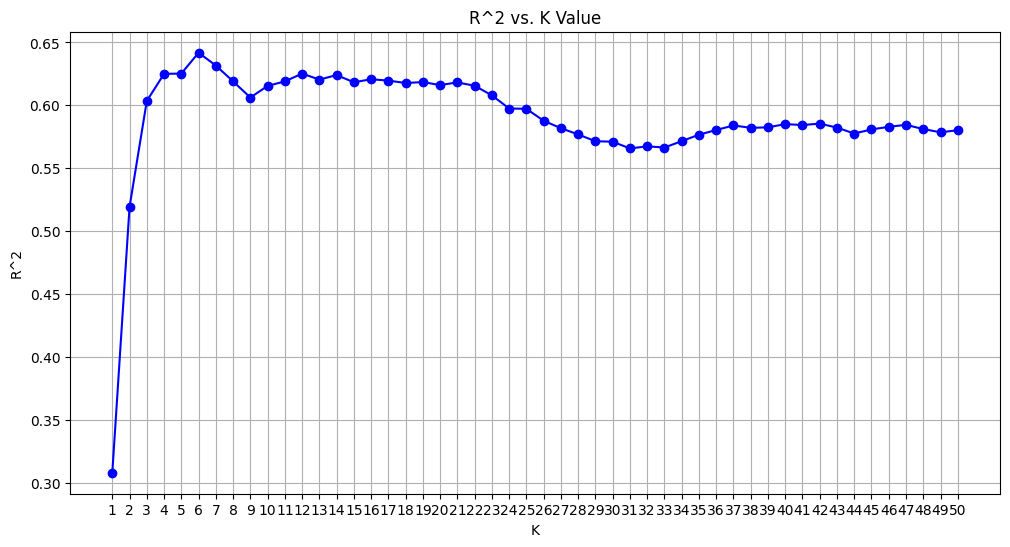

In [20]:
# Visualize K selection
k_range = range(1, len(r2_scores) + 1)

plt.figure(figsize=(12, 6))
plt.plot(k_range, r2_scores, marker='o', linestyle='-', color='b')
plt.title('R^2 vs. K Value')
plt.xlabel('K')
plt.ylabel('R^2')
plt.xticks(k_range)
plt.grid(True)
plt.show()

### 3.4/ Final KNN Evaluation

In [21]:
knn = KNN_regressor(best_k)
knn.fit(X_train, y_train)

pred_knn_log = knn.predict(X_test)
metrics = evaluate_log_predictions(y_test, pred_knn_log)

print_metrics(metrics)

Regression Metrics: 
------------------------------
R2        : 0.7902
MAE       : 4.2213
RMSE      : 5.6574
MAPE      : 0.1328


## APPROACH B: K-MEANS + KNN

### 3.5/ K-Means Class

In [22]:
class K_means:
    def __init__(self, k):
        self.k = k

    def fit(self, X, y):
        self.X = np.array(X, dtype=float)
        self.y = np.array(y, dtype=float)

    def choose_random(self):
        np.random.seed(42)
        idx = np.random.choice(len(self.X), size=self.k, replace=False)
        self.centers = self.X[idx]

    def assign_labels(self, X):
        X = np.array(X, dtype=float)
        return np.array([
            np.argmin(np.sum((self.centers - x) ** 2, axis=1))
            for x in X
        ])

    def update_centers(self):
        self.labels = self.assign_labels(self.X)
        self.centers = np.array([
            self.X[self.labels == i].mean(axis=0)
            if np.any(self.labels == i)
            else self.X[np.random.randint(len(self.X))]
            for i in range(self.k)
        ])


    def fit_loop(self, minval=1e-6, max_iter=300):
        self.choose_random()
        for _ in range(max_iter):
            old_centers = self.centers.copy()
            self.update_centers()
            shift = euclidean_distance(
                old_centers.flatten()[None, :],
                self.centers.flatten()
            )[0]

            if shift < minval:
                break

    def get_clusters(self):
        return [
            (self.X[self.labels == i], self.y[self.labels == i])
            for i in range(self.k)
        ]

    def calculate_inertia(self):
        inertia = 0.0
        for i, x in enumerate(self.X):
            c = self.labels[i]
            inertia += np.sum((x - self.centers[c]) ** 2)
        return inertia


### 3.6/ Find Optimal Number of Clusters

In [23]:
def silhouette_score(X, labels, metric='euclidean'):
    X = np.array(X)
    labels = np.array(labels)
    unique_labels = np.unique(labels)
    n_samples = len(X)
    if len(unique_labels) < 2 or n_samples <= len(unique_labels):
        return 0.0
    distance_matrix = np.sqrt(np.sum((X[:, np.newaxis] - X[np.newaxis, :]) ** 2, axis=2))
    A = np.zeros(n_samples)
    B = np.full(n_samples, np.inf)
    for label in unique_labels:
        mask_current = (labels == label)
        current_size = np.sum(mask_current)
        if current_size == 1:
            A[mask_current] = 0
        else:
            sum_dists = np.sum(distance_matrix[mask_current][:, mask_current], axis=1)
            A[mask_current] = sum_dists / (current_size - 1)

        for other_label in unique_labels:
            if label == other_label:
                continue

            mask_other = (labels == other_label)
            mean_dists_to_other = np.mean(distance_matrix[mask_current][:, mask_other], axis=1)
            B[mask_current] = np.minimum(B[mask_current], mean_dists_to_other)

    max_ab = np.maximum(A, B)
    s_scores = np.zeros(n_samples)
    valid_mask = max_ab > 0
    s_scores[valid_mask] = (B[valid_mask] - A[valid_mask]) / max_ab[valid_mask]
    for label in unique_labels:
        if np.sum(labels == label) == 1:
            s_scores[labels == label] = 0

    return np.mean(s_scores)

In [24]:
def find_optimal_k_clusters(X, y, min_k=2, max_k=10):
    inertias = []
    silhouettes = []

    K_range = range(min_k, max_k + 1)

    for k in K_range:
        km = K_means(k)
        km.fit(X, y)
        km.fit_loop()

        inertia = km.calculate_inertia()
        inertias.append(inertia)

        sil = silhouette_score(km.X, km.labels)
        silhouettes.append(sil)

        print(f"K={k}: Inertia={inertia:.2f}, Silhouette={sil:.4f}")

    best_k = K_range[np.argmax(silhouettes)]
    print(f"Best K: K = {best_k}")

    return best_k, inertias, silhouettes

In [25]:
best_k_clusters, inertias, silhouettes = find_optimal_k_clusters(X_train, y_train, min_k=2, max_k=10)

K=2: Inertia=47.65, Silhouette=0.3499
K=3: Inertia=34.91, Silhouette=0.3583
K=4: Inertia=30.74, Silhouette=0.3188
K=5: Inertia=26.75, Silhouette=0.2862
K=6: Inertia=21.39, Silhouette=0.3282
K=7: Inertia=20.32, Silhouette=0.2934
K=8: Inertia=19.05, Silhouette=0.2765
K=9: Inertia=17.38, Silhouette=0.2917
K=10: Inertia=15.65, Silhouette=0.3126
Best K: K = 3


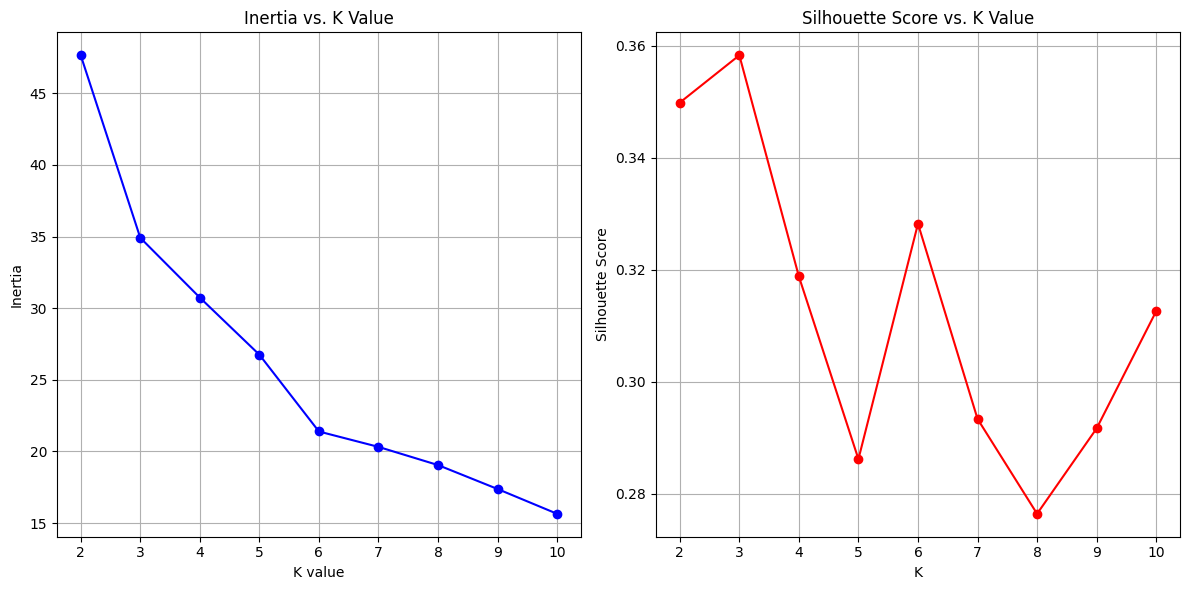

In [26]:
# Inertia and Silhouettes Score Visualization

def plot_inertia_silhouette(inertias, silhouettes):
    K_range_for_plot = range(2, 11)
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].plot(K_range_for_plot, inertias, marker='o', linestyle='-', color='b')
    axes[0].set_title('Inertia vs. K Value')
    axes[0].set_xlabel('K value')
    axes[0].set_ylabel('Inertia')
    axes[0].set_xticks(K_range_for_plot)
    axes[0].grid(True)

    axes[1].plot(K_range_for_plot, silhouettes, marker='o', linestyle='-', color='r')
    axes[1].set_title('Silhouette Score vs. K Value')
    axes[1].set_xlabel('K')
    axes[1].set_ylabel('Silhouette Score')
    axes[1].set_xticks(K_range_for_plot)
    axes[1].grid(True)
    plt.tight_layout()
    plt.show()

plot_inertia_silhouette(inertias, silhouettes)

### 3.7/ Final Training

In [27]:
kmeans = K_means(best_k_clusters)
kmeans.fit(X_train, y_train)
kmeans.fit_loop()

train_clusters = kmeans.assign_labels(X_train)
test_clusters = kmeans.assign_labels(X_test)

knn_models = []

for c in range(best_k_clusters):
    mask = train_clusters == c
    X_c, y_c = X_train[mask], y_train[mask]

    if len(X_c) < 5:
        knn_models.append(KNN_regressor(1))
        knn_models[-1].fit(X_c, y_c)
        continue

    # Find best k for KNN on each cluster
    X_tr_cluster, X_val_cluster, y_tr_cluster, y_val_cluster = train_test_split(
        X_c, y_c, test_size=0.2, random_state=42
    )
    
    best_k_knn, _ , _ = find_best_k_knn(X_tr_cluster, y_tr_cluster, X_val_cluster, y_val_cluster, k_max=20)
    knn = KNN_regressor(best_k_knn)
    knn.fit(X_c, y_c)
    knn_models.append(knn)

### K-Means Visualization

In [28]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [29]:
def plot_kmeans_pca(model):
    pca = PCA(n_components=2)
    X_2D = pca.fit_transform(model.X)
    centers_2D = pca.transform(model.centers)

    plt.figure(figsize=(7, 6))
    for c in range(model.k):
        plt.scatter(X_2D[model.labels == c, 0],
                    X_2D[model.labels == c, 1],
                    label=f"Cluster {c}")

    plt.scatter(centers_2D[:, 0], centers_2D[:, 1],
                marker='X', s=200, c='yellow', edgecolors='black')

    plt.title("K-Means Clusters (PCA Projection)")
    plt.legend()
    plt.grid(True)
    plt.show()

In [30]:
def plot_clusters_TSNE(model):
        labels = model.labels

        tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto')
        X_2D = tsne.fit_transform(model.X)

        plt.figure(figsize=(7, 6))
        for c in range(model.k):
          pts = X_2D[labels == c]
          plt.scatter(pts[:, 0], pts[:, 1], s=25, label=f"Cluster {c}")
        plt.title("K-Means Clusters (t-SNE 2D Projection)")
        plt.legend()
        plt.grid(True)
        plt.show()

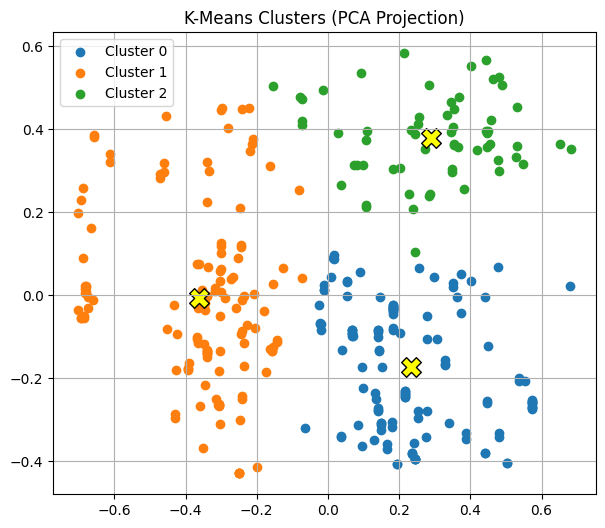

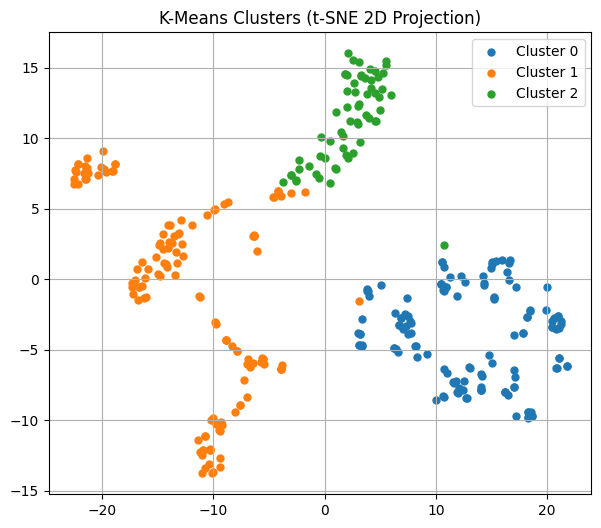

In [31]:
plot_kmeans_pca(kmeans)
plot_clusters_TSNE(kmeans)

### 3.8/ Final Evaluation

In [32]:
pred_kmeans_knn_log = np.array([
    knn_models[c].predict([X_test.iloc[i]])[0]
    for i, c in enumerate(test_clusters)
])
metrics_kmeans_knn = evaluate_log_predictions(y_test, pred_kmeans_knn_log)
print_metrics(metrics_kmeans_knn)

Regression Metrics: 
------------------------------
R2        : 0.7957
MAE       : 4.2193
RMSE      : 5.5819
MAPE      : 0.1358
